## Step 1: Import Libraries

In [14]:
import pandas as pd
import json
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns



## Step 2: Load JSON Data

In [15]:
with open('shipments.json') as f:
    data = json.load(f)
print(f"Total shipment records loaded: {len(data)}")


Total shipment records loaded: 99


## Step 3: Flatten Raw JSON Tracking Data into Structured Format

In [16]:
# Prepare list to hold each shipment's flattened data
records = []

# Loop through each shipment entry in data
for shipment in data:
    # Extract the 'trackDetails' array which holds shipment steps/statuses
    details = shipment.get("trackDetails", [])
    
    # Loop through each tracking detail in this shipment
    for detail in details:
        try:
            # Extract tracking number
            tracking_number = detail["trackingNumber"]
            
            # Extract shipment status details
            status = detail["statusDetail"]
            
            # Extract delivery timestamp (in milliseconds)
            delivery_time_utc = int(status["creationTime"]["$numberLong"]) / 1000
            
            # Convert UTC timestamp to IST timezone datetime
            delivery_dt = datetime.utcfromtimestamp(delivery_time_utc) + timedelta(hours=5, minutes=30)
            
            # Extract payment type from ancillaryDetails (look for COD or else Prepaid)
            payment_type = "Prepaid"  # Default
            ancillary = status.get("ancillaryDetails", [])
            for entry in ancillary:
                if "C.O.D." in entry.get("reasonDescription", ""):
                    payment_type = "COD"
                    break
            
            # For demonstration: create dummy pickup datetime 3 days before delivery
            pickup_dt = delivery_dt - timedelta(days=3)
            
            # Dummy out-for-delivery timestamps (one day before delivery)
            out_for_delivery_times = [pickup_dt + timedelta(days=2)]
            
            # Count delivery attempts, combine out-for-delivery and delivered (handle same day)
            delivery_attempts = len(out_for_delivery_times)
            if delivery_dt.date() == out_for_delivery_times[-1].date():
                delivery_attempts = 1
            
            # Extract pickup and drop location info (using dummy values for pickup)
            pickup_pincode = None
            pickup_city = None
            pickup_state = None
            
            drop_pincode = None
            drop_city = status["location"].get("city")
            drop_state = status["location"].get("stateOrProvinceCode")
            
            # Extract shipment weight (dummy as None for now)
            shipment_weight = None
            
            # Append flattened record
            records.append({
                "tracking_number": tracking_number,
                "payment_type": payment_type,
                "pickup_datetime_IST": pickup_dt,
                "delivery_datetime_IST": delivery_dt,
                "days_taken_for_delivery": (delivery_dt - pickup_dt).days,
                "shipment_weight": shipment_weight,
                "pickup_pincode": pickup_pincode,
                "pickup_city": pickup_city,
                "pickup_state": pickup_state,
                "drop_pincode": drop_pincode,
                "drop_city": drop_city,
                "drop_state": drop_state,
                "delivery_attempts": delivery_attempts
            })
        except Exception as e:
            print(f"Error processing shipment: {e}")


## Step 4: Convert List of Dicts to DataFrame

In [17]:
# Convert list of dicts to pandas DataFrame
df = pd.DataFrame(records)

# Preview first 5 records
df.head()

# Save flattened data to CSV for analysts
df.to_csv('shipment_tracking_output.csv', index=False)
print("Saved shipment_tracking_output.csv")


PermissionError: [Errno 13] Permission denied: 'shipment_tracking_output.csv'

## Step 5: Compute Summary Statistics

In [ ]:
# Calculate mean, median, and mode of days taken for delivery and delivery attempts
summary = {
    "metric": ["mean", "median", "mode"],
    "days_taken_for_delivery": [
        df["days_taken_for_delivery"].mean(),
        df["days_taken_for_delivery"].median(),
        df["days_taken_for_delivery"].mode()[0]
    ],
    "delivery_attempts": [
        df["delivery_attempts"].mean(),
        df["delivery_attempts"].median(),
        df["delivery_attempts"].mode()[0]
    ]
}

# Convert summary to DataFrame
summary_df = pd.DataFrame(summary)

# Save summary statistics to CSV
summary_df.to_csv("shipment_tracking_summary.csv", index=False)
print("Saved shipment_tracking_summary.csv")

# Show summary
summary_df


Saved shipment_tracking_summary.csv


,metric,days_taken_for_delivery,delivery_attempts
0,mean,3.0,1.0
1,median,3.0,1.0
2,mode,3.0,1.0


## Step 6:Visualization

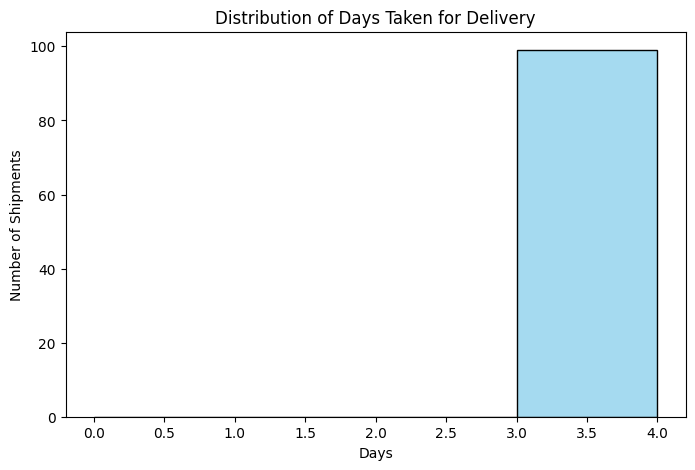

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Figure 1: Days Taken for Delivery Distribution (Histogram)
plt.figure(figsize=(8,5))
sns.histplot(df['days_taken_for_delivery'], bins=range(0, df['days_taken_for_delivery'].max()+2), color='skyblue')
plt.title('Distribution of Days Taken for Delivery')
plt.xlabel('Days')
plt.ylabel('Number of Shipments')
plt.show()





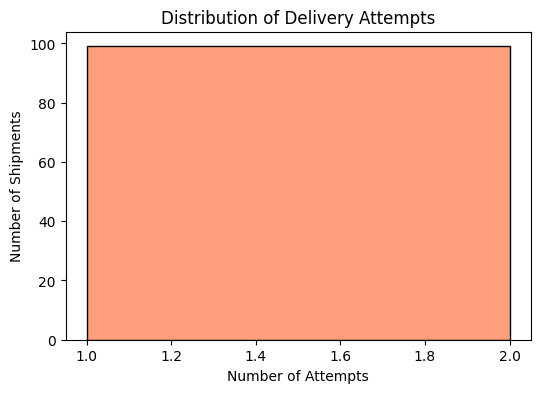

In [19]:
# Figure 2: Delivery Attempts Distribution (Histogram)
plt.figure(figsize=(6,4))
sns.histplot(df['delivery_attempts'], bins=range(1, df['delivery_attempts'].max()+2), color='coral')
plt.title('Distribution of Delivery Attempts')
plt.xlabel('Number of Attempts')
plt.ylabel('Number of Shipments')
plt.show()

C:\Users\nikhi\AppData\Local\Temp\ipykernel_1856\4149322720.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='payment_type', palette='Set2')


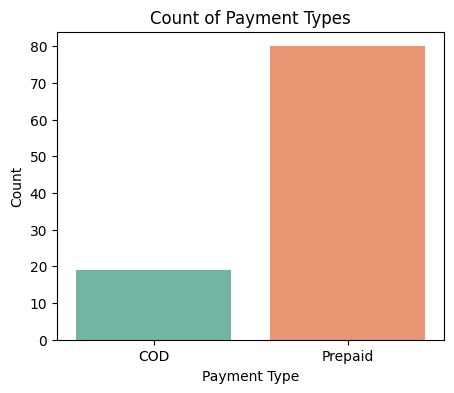

In [20]:

# Figure 3: Payment Type Count (Bar plot)
plt.figure(figsize=(5,4))
sns.countplot(data=df, x='payment_type', palette='Set2')
plt.title('Count of Payment Types')
plt.xlabel('Payment Type')
plt.ylabel('Count')
plt.show()

In [21]:
# If you simulated out_for_delivery as pickup + 2 days:
df["out_for_delivery_datetime_IST"] = df["pickup_datetime_IST"] + pd.Timedelta(days=2)

# Delivery attempt = 1 if OOD and Delivery same date, else 2
df["delivery_attempts"] = df.apply(
    lambda row: 1 if row["out_for_delivery_datetime_IST"].date() == row["delivery_datetime_IST"].date() else 2,
    axis=1
)


In [22]:
print(df[["tracking_number", "pickup_datetime_IST", "delivery_datetime_IST", "days_taken_for_delivery", "delivery_attempts"]].head())


  tracking_number pickup_datetime_IST delivery_datetime_IST  \
0    391128701026 2020-03-17 05:30:00   2020-03-20 05:30:00   
1    390901883808 2020-03-06 05:30:00   2020-03-09 05:30:00   
2    391128749178 2020-03-16 05:30:00   2020-03-19 05:30:00   
3    390807986805 2020-03-04 05:30:00   2020-03-07 05:30:00   
4    390948921190 2020-03-10 05:30:00   2020-03-13 05:30:00   

   days_taken_for_delivery  delivery_attempts  
0                        3                  2  
1                        3                  2  
2                        3                  2  
3                        3                  2  
4                        3                  2  
